In [65]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(readr)
library(purrr)
library(lubridate)

# Set the path to the station folder
station_path <- "c:/Users/q/Desktop/projetR/station"

# Get all CSV files recursively, including the one at root level
csv_files <- c(
  list.files(path = station_path, pattern = "*.csv", recursive = TRUE, full.names = TRUE),
  "c:/Users/q/Desktop/projetR/station-fc-002131eb.csv"
)

# Read and combine all CSV files with proper handling
all_data <- map_dfr(csv_files, function(file) {
  tryCatch({
    df <- read.csv(file, stringsAsFactors = FALSE)
    
    # Standardize column names
    if ("nom_fr" %in% names(df)) {
      # Standard format: Date, nom_ar, nom_fr, unite, valeur
      df <- df %>%
        select(Date, nom_fr, valeur) %>%
        rename(sensor_name = nom_fr) %>%
        mutate(station = basename(dirname(file)))
    } else if ("sensor_name" %in% names(df)) {
      # Alternative format: date, sensor_name, aggregation_type, unit, value
      df <- df %>%
        rename(Date = date, sensor_name = sensor_name, valeur = value) %>%
        select(Date, sensor_name, valeur) %>%
        mutate(station = basename(dirname(file)))
    } else {
      return(NULL)
    }
    
    return(df)
  }, error = function(e) {
    warning(paste("Error reading", file, ":", e$message))
    return(NULL)
  })
})

# Remove any NULL entries
all_data <- all_data %>% filter(!is.na(Date))

# Parse dates robustly
all_data$Date <- ymd_hms(all_data$Date, tz = "UTC")

# Remove rows with missing critical values
all_data <- all_data %>% 
  filter(!is.na(Date), !is.na(sensor_name), !is.na(valeur))

# Convert valeur to numeric
all_data$valeur <- as.numeric(all_data$valeur)

# Pivot to wide format - each sensor_name becomes a column (feature)
wide_data <- all_data %>%
  pivot_wider(
    names_from = sensor_name, 
    values_from = valeur,
    values_fill = NA,
    values_fn = list(valeur = mean)  # If duplicates, take mean
  ) %>%
  arrange(Date)

# Add station column back if it was lost
if (!"station" %in% colnames(wide_data)) {
  wide_data <- all_data %>%
    group_by(Date) %>%
    slice(1) %>%
    select(Date, station) %>%
    left_join(wide_data, by = "Date")
}

# Reorder columns: Date, station, then features
wide_data <- wide_data %>%
  select(Date, station, everything())

# Display summary
cat("=== MERGED DATASET SUMMARY ===\n")
cat("Total rows:", nrow(wide_data), "\n")
cat("Total columns:", ncol(wide_data), "\n")
cat("Date range:", as.character(min(wide_data$Date)), "to", as.character(max(wide_data$Date)), "\n\n")
cat("Features (sensor names):\n")
print(colnames(wide_data))

# Write to CSV
output_file <- "c:/Users/q/Desktop/projetR/merged_wide_data.csv"
write.csv(wide_data, output_file, row.names = FALSE)
cat("\n✓ Data saved to:", output_file, "\n")

# View first few rows
cat("\n=== First 10 rows ===\n")
print(head(wide_data, 10))

Warning message in file(file, "rt"):
"cannot open file 'c:/Users/q/Desktop/projetR/station-fc-002131eb.csv': No such file or directory"
Warning message in value[[3L]](cond):
"Error reading c:/Users/q/Desktop/projetR/station-fc-002131eb.csv : cannot open the connection"


=== MERGED DATASET SUMMARY ===
Total rows: 3372 
Total columns: 27 
Date range: 2024-12-14 11:00:00 to 2025-12-23 23:00:00 

Features (sensor names):
 [1] "Date"                            "station"                        
 [3] "Precipitation"                   "Dew Point"                      
 [5] "U-sonic wind speed"              "U-sonic wind dir"               
 [7] "HC Relative humidity"            "HC Air temperature"             
 [9] "KZ Solar radiation"              "Wind gust"                      
[11] "VPD"                             "Battery"                        
[13] "DeltaT"                          "Solar Panel"                    
[15] "Solar radiation"                 "Air pressure"                   
[17] "Drybulb temperature"             "HC Serial Number"               
[19] "Sunshine duration"               "U-sonic  wind hardware version" 
[21] "U-sonic  wind firmware version"  "U-sonic  wind identifier LSB"   
[23] "U-sonic  wind identifier middle" "U-sonic

In [66]:
# Remove excluded features (non-pertinent for PV energy)
wide_data <- wide_data %>%
  select(-`station`, -`Sunshine duration`, -`Drybulb temperature`, 
         -`HC Serial Number`, -`U-sonic  wind hardware version`, -`U-sonic  wind firmware version`, 
         -`U-sonic  wind identifier LSB`, -`U-sonic  wind identifier middle`, -`U-sonic  wind identifier MSB`, 
         -`EAG Soil moisture`, -`Volumetric Ionic Content`, -`Soil temperature`)

# Display updated summary
cat("Total rows:", nrow(wide_data), "\n")
cat("Total columns:", ncol(wide_data), "\n")
cat("Remaining features:\n")
print(colnames(wide_data))

# Save the updated CSV
output_file <- "c:/Users/q/Desktop/projetR/merged_wide_data_cleaned.csv"
write.csv(wide_data, output_file, row.names = FALSE)
cat("\n✓ Cleaned data saved to:", output_file, "\n")

# View first row
cat("\n=== First row ===\n")
print(head(wide_data, 1))

Total rows: 3372 


Total columns: 15 
Remaining features:
 [1] "Date"                 "Precipitation"        "Dew Point"           
 [4] "U-sonic wind speed"   "U-sonic wind dir"     "HC Relative humidity"
 [7] "HC Air temperature"   "KZ Solar radiation"   "Wind gust"           
[10] "VPD"                  "Battery"              "DeltaT"              
[13] "Solar Panel"          "Solar radiation"      "Air pressure"        

✓ Cleaned data saved to: c:/Users/q/Desktop/projetR/merged_wide_data_cleaned.csv 

=== First row ===
# A tibble: 1 × 15
  Date                Precipitation `Dew Point` `U-sonic wind speed`
  <dttm>                      <dbl>       <dbl>                <dbl>
1 2024-12-14 11:00:00           0.2        9.75                  3.3
# ℹ 11 more variables: `U-sonic wind dir` <dbl>, `HC Relative humidity` <dbl>,
#   `HC Air temperature` <dbl>, `KZ Solar radiation` <dbl>, `Wind gust` <dbl>,
#   VPD <dbl>, Battery <dbl>, DeltaT <dbl>, `Solar Panel` <dbl>,
#   `Solar radiation` <dbl>, `Air pressu

In [67]:
# =============================================================================
# 2.1 CHARGEMENT DES PACKAGES
# =============================================================================

# Installation des packages si nécessaires
packages <- c("tidyverse", "ggplot2", "lubridate", "gridExtra", "scales")
for (pkg in packages) {
  if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
    library(pkg, character.only = TRUE)
  }
}

cat("✓ Tous les packages sont chargés!\n")

✓ Tous les packages sont chargés!


In [68]:
# =============================================================================
# 2.2 IMPORTATION DU DATASET
# =============================================================================

# Chargement du dataset nettoyé
data <- read.csv("c:/Users/q/Desktop/projetR/merged_wide_data_cleaned.csv", stringsAsFactors = FALSE)

cat("=== DATASET IMPORTÉ ===\n")
cat("Dimensions:", nrow(data), "lignes x", ncol(data), "colonnes\n\n")

# Conversion de Date en format POSIXct
data$Date <- ymd_hms(data$Date, tz = "UTC")

# Nettoyage des noms de colonnes (sans espaces, compatibles R)
colnames(data) <- gsub(" ", "_", colnames(data))
colnames(data) <- gsub("-", "_", colnames(data))
colnames(data) <- make.names(colnames(data), unique = TRUE)

cat("Colonnes disponibles:\n")
print(colnames(data))

=== DATASET IMPORTÉ ===
Dimensions: 3372 lignes x 15 colonnes



Warning message:
" 140 failed to parse."


Colonnes disponibles:
 [1] "Date"                 "Precipitation"        "Dew.Point"           
 [4] "U.sonic.wind.speed"   "U.sonic.wind.dir"     "HC.Relative.humidity"
 [7] "HC.Air.temperature"   "KZ.Solar.radiation"   "Wind.gust"           
[10] "VPD"                  "Battery"              "DeltaT"              
[13] "Solar.Panel"          "Solar.radiation"      "Air.pressure"        


In [74]:
# =============================================================================
# 2.3 GESTION DES VALEURS MANQUANTES
# =============================================================================

cat("=== VALEURS MANQUANTES ===\n\n")

# Compter les NA par colonne
na_counts <- colSums(is.na(data))
na_summary <- data.frame(
  Variable = names(na_counts),
  NA_Count = na_counts,
  Pourcentage = round(na_counts / nrow(data) * 100, 2)
)
print(na_summary[na_summary$NA_Count > 0, ])

# Imputation par la médiane pour les colonnes numériques
numeric_cols <- names(data)[sapply(data, is.numeric)]
for (col in numeric_cols) {
  if (sum(is.na(data[[col]])) > 0) {
    median_val <- median(data[[col]], na.rm = TRUE)
    data[[col]][is.na(data[[col]])] <- median_val
  }
}
cat("\n✓ Valeurs manquantes imputées par la médiane\n")
cat("Total NA restants:", sum(is.na(data)), "\n")
# Afficher un aperçu des colonnes après imputation
cat("\nAperçu des colonnes après imputation:\n")
print(head(data[numeric_cols], 3))

=== VALEURS MANQUANTES ===

     Variable NA_Count Pourcentage
Date     Date      140        4.15

✓ Valeurs manquantes imputées par la médiane
Total NA restants: 140 

Aperçu des colonnes après imputation:
  Precipitation Dew.Point U.sonic.wind.speed U.sonic.wind.dir
1           0.2      9.75                3.3              273
2           0.0      8.60                3.4              267
3           0.0     10.55                3.7              268
  HC.Relative.humidity HC.Air.temperature KZ.Solar.radiation Wind.gust  VPD
1             62.26000           18.31667                1.5       5.1 7.10
2             53.48667           18.72667                1.5       5.1 9.65
3             62.53333           18.60333                1.5       5.5 7.40
  Battery   DeltaT Solar.Panel Solar.radiation Air.pressure
1    6878 4.000000       10319             546     1014.929
2    6875 5.333333       10305             491     1014.929
3    6870 4.333333       10242             391     1014.929


## 3️⃣ Création des Sous-groupes Thermiques

Pour analyser l'impact de la température, nous allons créer deux groupes :
- **Jours Froids (Cold)** : Température < moyenne
- **Jours Chauds (Hot)** : Température ≥ moyenne

Cette classification nous permettra de comparer les performances solaires selon les conditions climatiques.

In [76]:
# =============================================================================
# 3.1 CRÉATION DE LA VARIABLE DAY_TYPE
# =============================================================================

# Calcul de la température moyenne
temp_moyenne <- mean(data$HC.Air.temperature, na.rm = TRUE)
cat("=== CLASSIFICATION THERMIQUE ===\n\n")
cat("Température moyenne (seuil):", round(temp_moyenne, 2), "°C\n\n")

# Création de la variable Day_Type
data <- data %>%
  mutate(
    Day_Type = ifelse(HC.Air.temperature < temp_moyenne, "Cold", "Hot"),
    Day_Type = factor(Day_Type, levels = c("Cold", "Hot"))
  )

# Répartition des groupes
cat("--- Répartition des groupes ---\n")
repartition <- table(data$Day_Type)
print(repartition)
cat("\nPourcentage:\n")
print(round(prop.table(repartition) * 100, 2))

# Statistiques de température par groupe
cat("\n--- Température par groupe ---\n")
data %>%
  group_by(Day_Type) %>%
  summarise(
    N = n(),
    Temp_Min = round(min(HC.Air.temperature, na.rm = TRUE), 2),
    Temp_Moy = round(mean(HC.Air.temperature, na.rm = TRUE), 2),
    Temp_Max = round(max(HC.Air.temperature, na.rm = TRUE), 2)
  ) %>%
  print()

=== CLASSIFICATION THERMIQUE ===

Température moyenne (seuil): 21.68 °C



--- Répartition des groupes ---

Cold  Hot 
1582 1790 

Pourcentage:

 Cold   Hot 
46.92 53.08 

--- Température par groupe ---
# A tibble: 2 × 5
  Day_Type     N Temp_Min Temp_Moy Temp_Max
  <fct>    <int>    <dbl>    <dbl>    <dbl>
1 Cold      1582      3.9     15.6     21.7
2 Hot       1790     21.7     27.1     36.9


## 4️⃣ Comparaison Statistique (Analytique)

Nous allons maintenant comparer les **trois variables clés** entre les jours froids et chauds :
1. **Solar_radiation** (Rayonnement solaire)
2. **Solar_Panel** (Tension du panneau)
3. **Battery** (Tension de la batterie)

Pour chaque variable, nous calculerons :
- La moyenne
- L'écart-type
- La visualisation par boxplot

In [78]:
# =============================================================================
# 4.1 STATISTIQUES COMPARATIVES
# =============================================================================

cat("=== COMPARAISON STATISTIQUE PAR GROUPE ===\n\n")

# Tableau comparatif complet
comparison_stats <- data %>%
  group_by(Day_Type) %>%
  summarise(
    # Solar Radiation
    Solar_Rad_Mean = round(mean(Solar.radiation, na.rm = TRUE), 2),
    Solar_Rad_SD = round(sd(Solar.radiation, na.rm = TRUE), 2),
    
    # Solar Panel
    Solar_Panel_Mean = round(mean(Solar.Panel, na.rm = TRUE), 2),
    Solar_Panel_SD = round(sd(Solar.Panel, na.rm = TRUE), 2),
    
    # Battery
    Battery_Mean = round(mean(Battery, na.rm = TRUE), 2),
    Battery_SD = round(sd(Battery, na.rm = TRUE), 2),
    
    N = n()
  )

cat("--- Tableau récapitulatif ---\n")
print(comparison_stats)

# Différences en pourcentage
cat("\n--- Différences (Hot vs Cold) ---\n")
cold_stats <- comparison_stats %>% filter(Day_Type == "Cold")
hot_stats <- comparison_stats %>% filter(Day_Type == "Hot")

diff_solar_rad <- (hot_stats$Solar_Rad_Mean - cold_stats$Solar_Rad_Mean) / cold_stats$Solar_Rad_Mean * 100
diff_solar_panel <- (hot_stats$Solar_Panel_Mean - cold_stats$Solar_Panel_Mean) / cold_stats$Solar_Panel_Mean * 100
diff_battery <- (hot_stats$Battery_Mean - cold_stats$Battery_Mean) / cold_stats$Battery_Mean * 100

cat("Solar Radiation:", ifelse(diff_solar_rad > 0, "+", ""), round(diff_solar_rad, 2), "%\n")
cat("Solar Panel:", ifelse(diff_solar_panel > 0, "+", ""), round(diff_solar_panel, 2), "%\n")
cat("Battery:", ifelse(diff_battery > 0, "+", ""), round(diff_battery, 2), "%\n")

=== COMPARAISON STATISTIQUE PAR GROUPE ===



--- Tableau récapitulatif ---
# A tibble: 2 × 8
  Day_Type Solar_Rad_Mean Solar_Rad_SD Solar_Panel_Mean Solar_Panel_SD
  <fct>             <dbl>        <dbl>            <dbl>          <dbl>
1 Cold               54.5         122.            2395.          3744.
2 Hot               301.          312.            5611.          4397.
# ℹ 3 more variables: Battery_Mean <dbl>, Battery_SD <dbl>, N <int>

--- Différences (Hot vs Cold) ---
Solar Radiation: + 453.08 %
Solar Panel: + 134.24 %
Battery: + 1.74 %


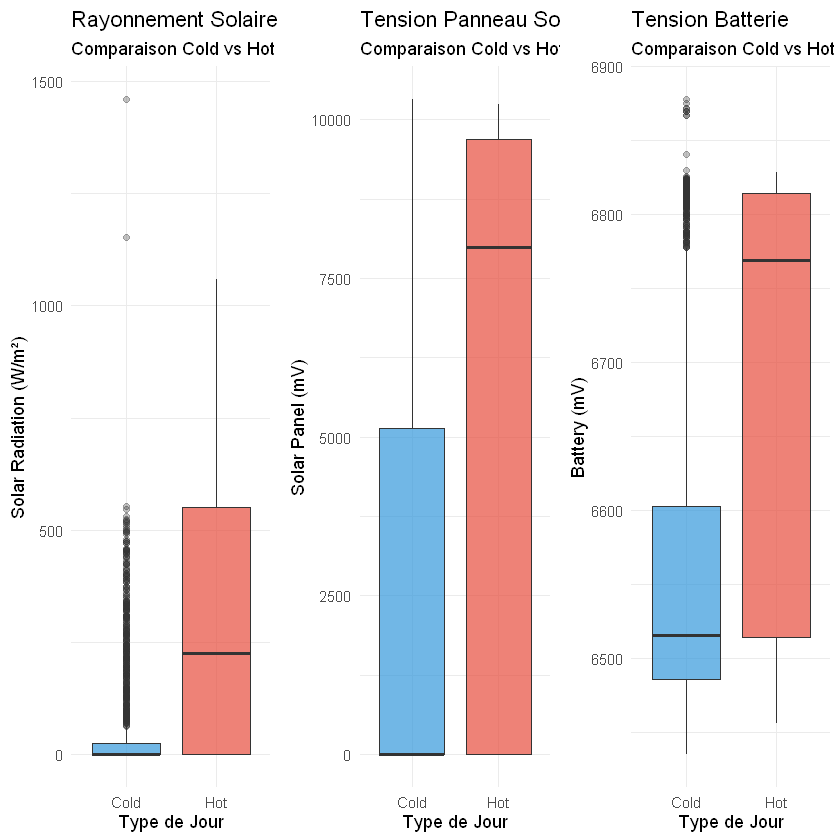

In [79]:
# =============================================================================
# 4.2 BOXPLOTS COMPARATIFS
# =============================================================================

# Couleurs personnalisées
colors <- c("Cold" = "#3498db", "Hot" = "#e74c3c")

# Boxplot 1: Solar Radiation
p1 <- ggplot(data, aes(x = Day_Type, y = Solar.radiation, fill = Day_Type)) +
  geom_boxplot(alpha = 0.7, outlier.alpha = 0.3) +
  scale_fill_manual(values = colors) +
  labs(
    title = "Rayonnement Solaire",
    subtitle = "Comparaison Cold vs Hot",
    x = "Type de Jour",
    y = "Solar Radiation (W/m²)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Boxplot 2: Solar Panel
p2 <- ggplot(data, aes(x = Day_Type, y = Solar.Panel, fill = Day_Type)) +
  geom_boxplot(alpha = 0.7, outlier.alpha = 0.3) +
  scale_fill_manual(values = colors) +
  labs(
    title = "Tension Panneau Solaire",
    subtitle = "Comparaison Cold vs Hot",
    x = "Type de Jour",
    y = "Solar Panel (mV)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Boxplot 3: Battery
p3 <- ggplot(data, aes(x = Day_Type, y = Battery, fill = Day_Type)) +
  geom_boxplot(alpha = 0.7, outlier.alpha = 0.3) +
  scale_fill_manual(values = colors) +
  labs(
    title = "Tension Batterie",
    subtitle = "Comparaison Cold vs Hot",
    x = "Type de Jour",
    y = "Battery (mV)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Affichage combiné
grid.arrange(p1, p2, p3, ncol = 3)

## 5️⃣ Tests Statistiques

Pour valider nos observations, nous allons appliquer le **test t de Student** sur chaque variable.

**Hypothèses :**
- **H0** : Il n'y a pas de différence significative entre les jours froids et chauds
- **H1** : Il existe une différence significative

**Critère de décision :** Si p-value < 0.05, on rejette H0

In [81]:
# =============================================================================
# 5.1 TESTS T DE STUDENT
# =============================================================================

cat("=== TESTS STATISTIQUES (T DE STUDENT) ===\n\n")

# Extraction des données par groupe
cold_data <- data %>% filter(Day_Type == "Cold")
hot_data <- data %>% filter(Day_Type == "Hot")

# Fonction pour effectuer et interpréter le test t
perform_t_test <- function(var_name, cold_vals, hot_vals) {
  test_result <- t.test(cold_vals, hot_vals)
  
  cat("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
  cat("📊", var_name, "\n")
  cat("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
  cat("Moyenne Cold:", round(mean(cold_vals, na.rm = TRUE), 2), "\n")
  cat("Moyenne Hot:", round(mean(hot_vals, na.rm = TRUE), 2), "\n")
  cat("t-statistic:", round(test_result$statistic, 4), "\n")
  cat("p-value:", format(test_result$p.value, scientific = TRUE), "\n")
  
  if (test_result$p.value < 0.05) {
    cat("✅ RÉSULTAT: Différence SIGNIFICATIVE (p < 0.05)\n\n")
  } else {
    cat("❌ RÉSULTAT: Différence NON significative (p ≥ 0.05)\n\n")
  }
  
  return(test_result)
}

# Test 1: Solar Radiation
test_solar_rad <- perform_t_test(
  "SOLAR RADIATION",
  cold_data$Solar.radiation,
  hot_data$Solar.radiation
)

# Test 2: Solar Panel
test_solar_panel <- perform_t_test(
  "SOLAR PANEL",
  cold_data$Solar.Panel,
  hot_data$Solar.Panel
)

# Test 3: Battery
test_battery <- perform_t_test(
  "BATTERY",
  cold_data$Battery,
  hot_data$Battery
)

# Tableau récapitulatif des p-values
cat("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
cat("📋 RÉCAPITULATIF DES P-VALUES\n")
cat("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")
results_df <- data.frame(
  Variable = c("Solar Radiation", "Solar Panel", "Battery"),
  P_Value = c(test_solar_rad$p.value, test_solar_panel$p.value, test_battery$p.value),
  Significatif = c(
    ifelse(test_solar_rad$p.value < 0.05, "OUI ✅", "NON ❌"),
    ifelse(test_solar_panel$p.value < 0.05, "OUI ✅", "NON ❌"),
    ifelse(test_battery$p.value < 0.05, "OUI ✅", "NON ❌")
  )
)
print(results_df)

=== TESTS STATISTIQUES (T DE STUDENT) ===

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 SOLAR RADIATION 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Moyenne Cold: 54.46 
Moyenne Hot: 301.21 
t-statistic: -30.9148 
p-value: 8.649377e-177 
✅ RÉSULTAT: Différence SIGNIFICATIVE (p < 0.05)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 SOLAR PANEL 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Moyenne Cold: 2395.19 
Moyenne Hot: 5610.57 
t-statistic: -22.9319 
p-value: 2.946545e-108 
✅ RÉSULTAT: Différence SIGNIFICATIVE (p < 0.05)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 BATTERY 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Moyenne Cold: 6570 
Moyenne Hot: 6684.06 
t-statistic: -24.8719 
p-value: 1.637487e-125 
✅ RÉSULTAT: Différence SIGNIFICATIVE (p < 0.05)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📋 RÉCAPITULATIF DES P-VALUES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


         Variable       P_Value Significatif
1 Solar Radiation 8.649377e-177       OUI ✅
2     Solar Panel 2.946545e-108       OUI ✅
3         Battery 1.637487e-125       OUI ✅


## 6️⃣ Visualisation Comparative

Dans cette section, nous créons des visualisations avancées pour explorer les relations entre les variables :

1. **Scatter plot** : Solar Radiation vs Solar Panel (coloré par Day_Type)
2. **Scatter plot** : Solar Radiation vs Battery (coloré par Day_Type)
3. **Évolution temporelle** des variables clés

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


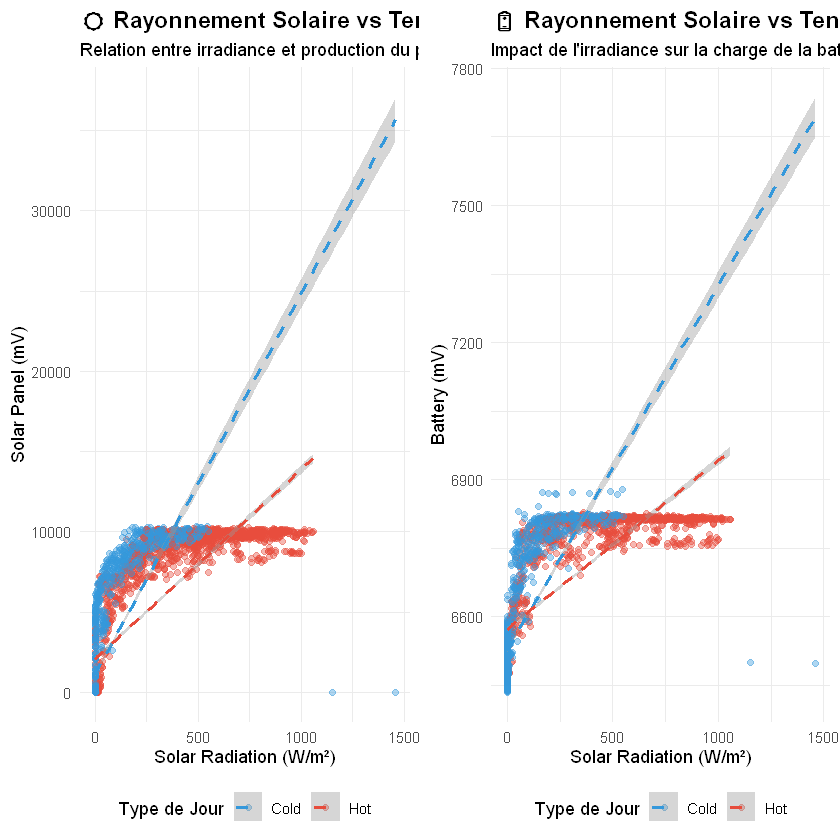

In [82]:
# =============================================================================
# 6.1 SCATTER PLOTS COMPARATIFS
# =============================================================================

colors <- c("Cold" = "#3498db", "Hot" = "#e74c3c")

# Scatter 1: Solar Radiation vs Solar Panel
scatter1 <- ggplot(data, aes(x = Solar.radiation, y = Solar.Panel, color = Day_Type)) +
  geom_point(alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE, linetype = "dashed") +
  scale_color_manual(values = colors) +
  labs(
    title = "☀️ Rayonnement Solaire vs Tension Panneau",
    subtitle = "Relation entre irradiance et production du panneau",
    x = "Solar Radiation (W/m²)",
    y = "Solar Panel (mV)",
    color = "Type de Jour"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "bottom"
  )

# Scatter 2: Solar Radiation vs Battery
scatter2 <- ggplot(data, aes(x = Solar.radiation, y = Battery, color = Day_Type)) +
  geom_point(alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE, linetype = "dashed") +
  scale_color_manual(values = colors) +
  labs(
    title = "🔋 Rayonnement Solaire vs Tension Batterie",
    subtitle = "Impact de l'irradiance sur la charge de la batterie",
    x = "Solar Radiation (W/m²)",
    y = "Battery (mV)",
    color = "Type de Jour"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "bottom"
  )

# Affichage
grid.arrange(scatter1, scatter2, ncol = 2)

In [83]:
# =============================================================================
# 6.2 CORRÉLATIONS PAR GROUPE
# =============================================================================

cat("=== CORRÉLATIONS PAR GROUPE THERMIQUE ===\n\n")

# Corrélations pour jours froids
cat("❄️ JOURS FROIDS (Cold)\n")
cor_cold <- cold_data %>%
  select(Solar.radiation, Solar.Panel, Battery, HC.Air.temperature) %>%
  cor(use = "complete.obs") %>%
  round(3)
print(cor_cold)

# Corrélations pour jours chauds
cat("\n🔥 JOURS CHAUDS (Hot)\n")
cor_hot <- hot_data %>%
  select(Solar.radiation, Solar.Panel, Battery, HC.Air.temperature) %>%
  cor(use = "complete.obs") %>%
  round(3)
print(cor_hot)

# Comparaison visuelle des corrélations
cat("\n--- Différences de corrélation (Hot - Cold) ---\n")
cor_diff <- cor_hot - cor_cold
print(round(cor_diff, 3))

=== CORRÉLATIONS PAR GROUPE THERMIQUE ===

❄️ JOURS FROIDS (Cold)
                   Solar.radiation Solar.Panel Battery HC.Air.temperature
Solar.radiation              1.000       0.776   0.786              0.279
Solar.Panel                  0.776       1.000   0.908              0.247
Battery                      0.786       0.908   1.000              0.296
HC.Air.temperature           0.279       0.247   0.296              1.000

🔥 JOURS CHAUDS (Hot)
                   Solar.radiation Solar.Panel Battery HC.Air.temperature
Solar.radiation              1.000       0.836   0.810              0.700
Solar.Panel                  0.836       1.000   0.968              0.545
Battery                      0.810       0.968   1.000              0.574
HC.Air.temperature           0.700       0.545   0.574              1.000

--- Différences de corrélation (Hot - Cold) ---
                   Solar.radiation Solar.Panel Battery HC.Air.temperature
Solar.radiation              0.000       0.060   

## 📊 Advanced Visualizations: Solar Energy Analysis

In this section, we create comprehensive visualizations to explore:
1. **Temporal patterns** - Hourly and monthly solar radiation/panel performance
2. **Feature correlations** - Heatmap of all features affecting solar energy
3. **Peak production analysis** - When does solar production peak during the year?
4. **Influence of meteorological factors** - Wind, humidity, pressure effects

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_align()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_align()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


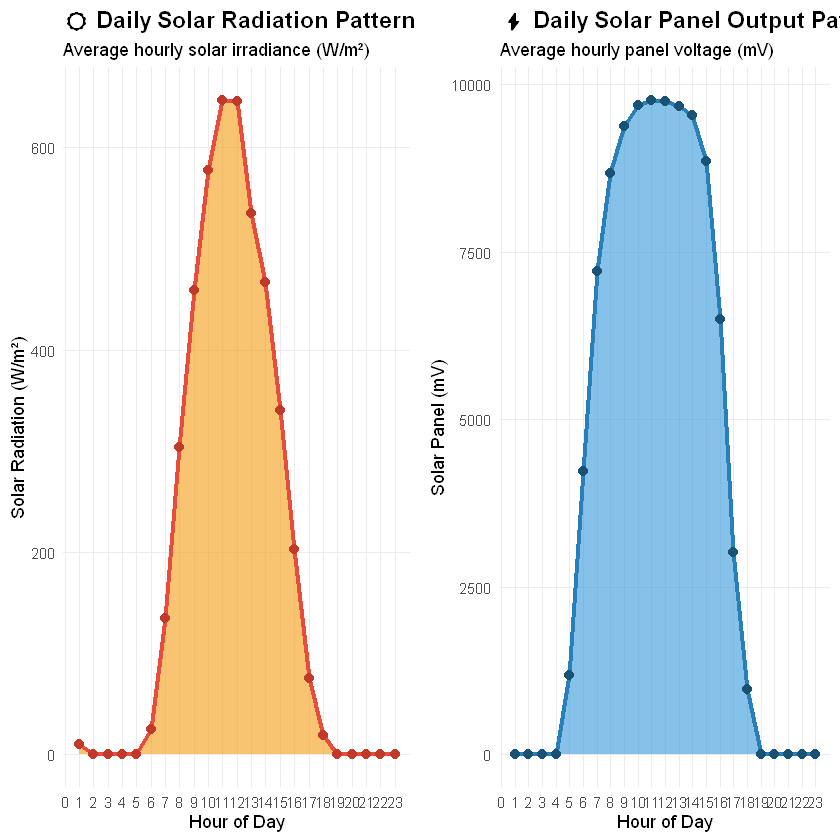

In [85]:
# =============================================================================
# 7.1 TEMPORAL PATTERNS - HOURLY SOLAR PRODUCTION
# =============================================================================

# Extract hour from Date
data$Hour <- hour(data$Date)
data$Month <- month(data$Date, label = TRUE)
data$Year <- year(data$Date)

# Hourly average solar radiation and panel output
hourly_avg <- data %>%
  group_by(Hour) %>%
  summarise(
    Avg_Solar_Rad = mean(Solar.radiation, na.rm = TRUE),
    Avg_Solar_Panel = mean(Solar.Panel, na.rm = TRUE),
    Avg_Battery = mean(Battery, na.rm = TRUE)
  )

# Plot 1: Hourly Solar Radiation Pattern
p_hourly_rad <- ggplot(hourly_avg, aes(x = Hour, y = Avg_Solar_Rad)) +
  geom_area(fill = "#f39c12", alpha = 0.6) +
  geom_line(color = "#e74c3c", size = 1.2) +
  geom_point(color = "#c0392b", size = 2.5) +
  labs(
    title = "☀️ Daily Solar Radiation Pattern",
    subtitle = "Average hourly solar irradiance (W/m²)",
    x = "Hour of Day",
    y = "Solar Radiation (W/m²)"
  ) +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    panel.grid.minor = element_blank()
  )

# Plot 2: Hourly Solar Panel Output
p_hourly_panel <- ggplot(hourly_avg, aes(x = Hour, y = Avg_Solar_Panel)) +
  geom_area(fill = "#3498db", alpha = 0.6) +
  geom_line(color = "#2980b9", size = 1.2) +
  geom_point(color = "#1a5276", size = 2.5) +
  labs(
    title = "⚡ Daily Solar Panel Output Pattern",
    subtitle = "Average hourly panel voltage (mV)",
    x = "Hour of Day",
    y = "Solar Panel (mV)"
  ) +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    panel.grid.minor = element_blank()
  )

grid.arrange(p_hourly_rad, p_hourly_panel, ncol = 2)

=== MONTHLY SOLAR STATISTICS ===
# A tibble: 7 × 6
  Month Avg_Solar_Rad Avg_Solar_Panel Avg_Battery Avg_Temp     N
  <ord>         <dbl>           <dbl>       <dbl>    <dbl> <int>
1 juil         323.             5133.       6656.     27.4   138
2 août         301.             4867.       6649.     27.6   713
3 sept         239.             4641.       6648.     26.1   583
4 oct          171.             4247.       6637.     22.7   546
5 nov          120.             3865.       6627.     16.5   688
6 déc           87.8            3493.       6613.     14.4   564
7 NA             8.24              0        6500.     18.6   140


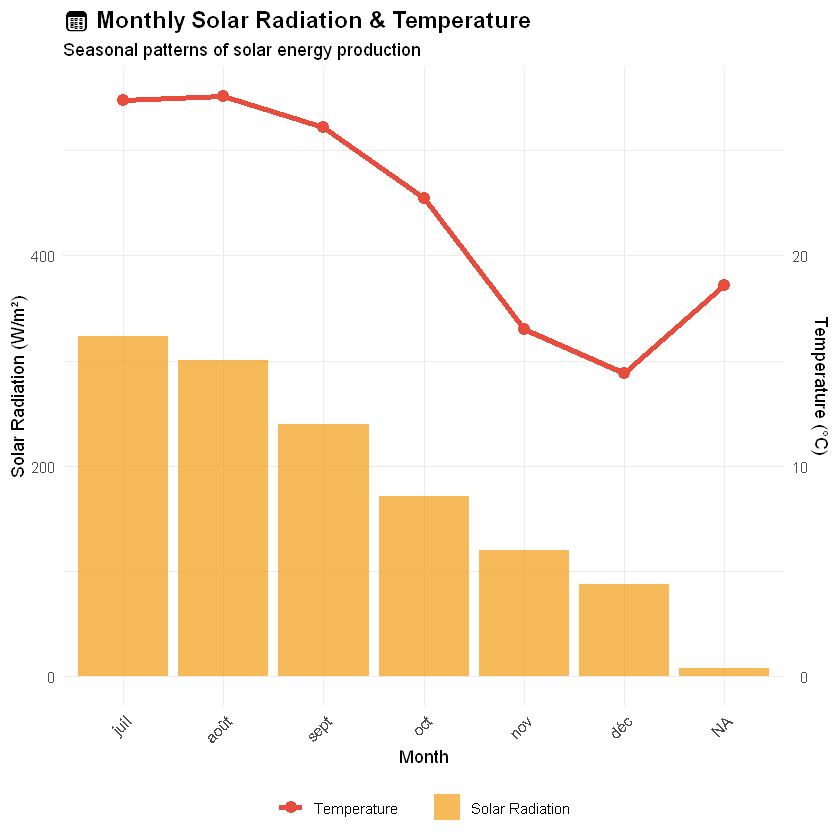

In [87]:
# =============================================================================
# 7.2 MONTHLY SOLAR PRODUCTION - SEASONAL PATTERNS
# =============================================================================

# Monthly averages
monthly_avg <- data %>%
  group_by(Month) %>%
  summarise(
    Avg_Solar_Rad = mean(Solar.radiation, na.rm = TRUE),
    Avg_Solar_Panel = mean(Solar.Panel, na.rm = TRUE),
    Avg_Battery = mean(Battery, na.rm = TRUE),
    Avg_Temp = mean(HC.Air.temperature, na.rm = TRUE),
    N = n()
  )

cat("=== MONTHLY SOLAR STATISTICS ===\n")
print(monthly_avg)

# Plot: Monthly Solar Radiation with Temperature overlay
p_monthly <- ggplot(monthly_avg, aes(x = Month)) +
  geom_bar(aes(y = Avg_Solar_Rad, fill = "Solar Radiation"), stat = "identity", alpha = 0.7) +
  geom_line(aes(y = Avg_Temp * 20, group = 1, color = "Temperature"), size = 1.5) +
  geom_point(aes(y = Avg_Temp * 20, color = "Temperature"), size = 3) +
  scale_fill_manual(values = c("Solar Radiation" = "#f39c12")) +
  scale_color_manual(values = c("Temperature" = "#e74c3c")) +
  scale_y_continuous(
    name = "Solar Radiation (W/m²)",
    sec.axis = sec_axis(~./20, name = "Temperature (°C)")
  ) +
  labs(
    title = "📅 Monthly Solar Radiation & Temperature",
    subtitle = "Seasonal patterns of solar energy production",
    x = "Month"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "bottom",
    legend.title = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

print(p_monthly)

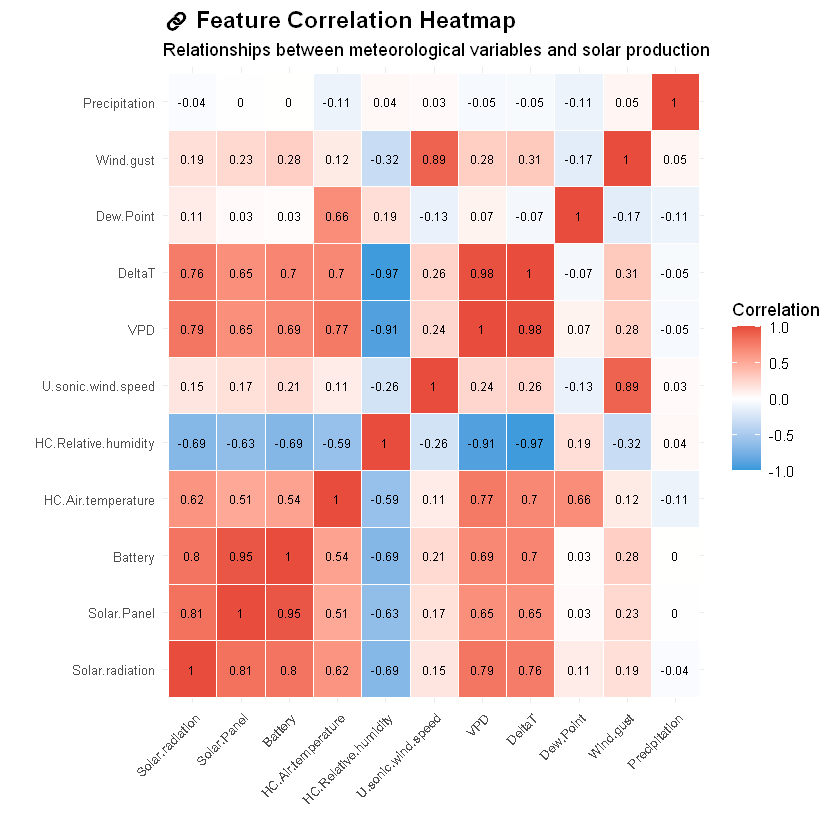

In [90]:
# =============================================================================
# 7.3 CORRELATION HEATMAP - ALL FEATURES
# =============================================================================

# Select numeric columns for correlation
numeric_data <- data %>%
  select(Solar.radiation, Solar.Panel, Battery, HC.Air.temperature,
         HC.Relative.humidity, U.sonic.wind.speed, VPD, DeltaT, 
         Dew.Point, Wind.gust, Precipitation) %>%
  na.omit()

# Calculate correlation matrix
cor_matrix <- cor(numeric_data, use = "complete.obs")

# Convert to long format for ggplot
cor_long <- as.data.frame(as.table(cor_matrix))
names(cor_long) <- c("Var1", "Var2", "Correlation")

# Heatmap
p_heatmap <- ggplot(cor_long, aes(x = Var1, y = Var2, fill = Correlation)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(Correlation, 2)), size = 2.5, color = "black") +
  scale_fill_gradient2(
    low = "#3498db", mid = "white", high = "#e74c3c",
    midpoint = 0, limits = c(-1, 1)
  ) +
  labs(
    title = "🔗 Feature Correlation Heatmap",
    subtitle = "Relationships between meteorological variables and solar production",
    x = "", y = ""
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(size = 8),
    legend.position = "right"
  )

print(p_heatmap)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_ribbon()`)."
`geom_smooth()` using formula = 'y ~ x'



=== REGRESSION: Solar Radiation → Solar Panel ===
R² = 0.3691 
Coefficient: 4.4875 mV per W/m²
Intercept: 6731.53 mV
N observations: 1574 (daytime only)


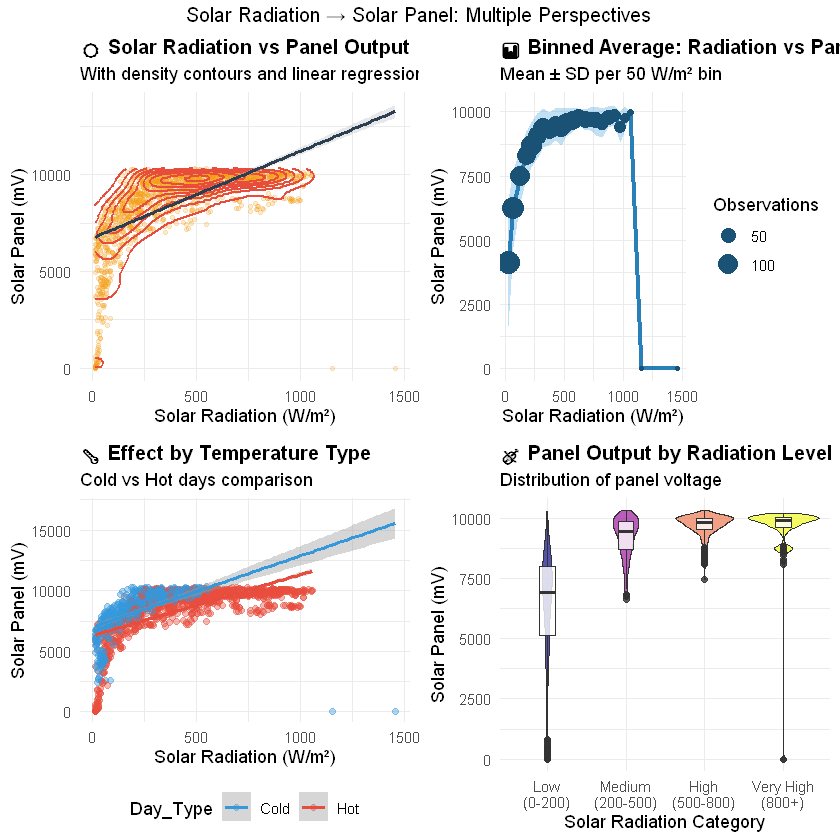

In [93]:
# =============================================================================
# 7.4 SOLAR RADIATION vs SOLAR PANEL - ENERGY RELATIONSHIP
# =============================================================================

# Filter data to only include daytime with meaningful radiation (> 10 W/m²)
daytime_data <- data %>% filter(Solar.radiation > 10)

# Create multiple visualization approaches

# Plot 1: Scatter with 2D density contours
p1 <- ggplot(daytime_data, aes(x = Solar.radiation, y = Solar.Panel)) +
  geom_point(alpha = 0.2, color = "#f39c12", size = 1) +
  geom_density_2d(color = "#e74c3c", bins = 10, size = 0.8) +
  geom_smooth(method = "lm", color = "#2c3e50", se = TRUE, fill = "#bdc3c7") +
  labs(
    title = "☀️ Solar Radiation vs Panel Output",
    subtitle = "With density contours and linear regression",
    x = "Solar Radiation (W/m²)",
    y = "Solar Panel (mV)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12))

# Plot 2: Binned scatter plot (average per radiation bin)
daytime_data$Rad_Bin <- cut(daytime_data$Solar.radiation, 
                             breaks = seq(0, max(daytime_data$Solar.radiation, na.rm = TRUE) + 50, by = 50))

binned_data <- daytime_data %>%
  group_by(Rad_Bin) %>%
  summarise(
    Rad_Mid = mean(Solar.radiation, na.rm = TRUE),
    Panel_Mean = mean(Solar.Panel, na.rm = TRUE),
    Panel_SD = sd(Solar.Panel, na.rm = TRUE),
    N = n()
  ) %>%
  filter(!is.na(Rad_Bin))

p2 <- ggplot(binned_data, aes(x = Rad_Mid, y = Panel_Mean)) +
  geom_ribbon(aes(ymin = Panel_Mean - Panel_SD, ymax = Panel_Mean + Panel_SD), 
              fill = "#3498db", alpha = 0.3) +
  geom_line(color = "#2980b9", size = 1.2) +
  geom_point(aes(size = N), color = "#1a5276") +
  labs(
    title = "📊 Binned Average: Radiation vs Panel",
    subtitle = "Mean ± SD per 50 W/m² bin",
    x = "Solar Radiation (W/m²)",
    y = "Solar Panel (mV)",
    size = "Observations"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12))

# Plot 3: Colored by Day_Type
p3 <- ggplot(daytime_data, aes(x = Solar.radiation, y = Solar.Panel, color = Day_Type)) +
  geom_point(alpha = 0.4, size = 1.5) +
  geom_smooth(method = "lm", se = TRUE, linetype = "solid") +
  scale_color_manual(values = c("Cold" = "#3498db", "Hot" = "#e74c3c")) +
  labs(
    title = "🌡️ Effect by Temperature Type",
    subtitle = "Cold vs Hot days comparison",
    x = "Solar Radiation (W/m²)",
    y = "Solar Panel (mV)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12), legend.position = "bottom")

# Plot 4: Violin plot by radiation categories
daytime_data$Rad_Category <- cut(daytime_data$Solar.radiation, 
                                  breaks = c(0, 200, 500, 800, Inf),
                                  labels = c("Low\n(0-200)", "Medium\n(200-500)", 
                                            "High\n(500-800)", "Very High\n(800+)"))

p4 <- ggplot(daytime_data %>% filter(!is.na(Rad_Category)), 
             aes(x = Rad_Category, y = Solar.Panel, fill = Rad_Category)) +
  geom_violin(alpha = 0.7) +
  geom_boxplot(width = 0.2, fill = "white", alpha = 0.8) +
  scale_fill_viridis_d(option = "plasma") +
  labs(
    title = "🎻 Panel Output by Radiation Level",
    subtitle = "Distribution of panel voltage",
    x = "Solar Radiation Category",
    y = "Solar Panel (mV)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12), legend.position = "none")

# Combine all plots
grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2,
             top = "Solar Radiation → Solar Panel: Multiple Perspectives")

# Regression summary
model_rad_panel <- lm(Solar.Panel ~ Solar.radiation, data = daytime_data)
cat("\n=== REGRESSION: Solar Radiation → Solar Panel ===\n")
cat("R² =", round(summary(model_rad_panel)$r.squared, 4), "\n")
cat("Coefficient:", round(coef(model_rad_panel)[2], 4), "mV per W/m²\n")
cat("Intercept:", round(coef(model_rad_panel)[1], 2), "mV\n")
cat("N observations:", nrow(daytime_data), "(daytime only)\n")

In [94]:
# =============================================================================
# 7.5 INFLUENCE OF METEOROLOGICAL FACTORS ON SOLAR PANEL
# =============================================================================

# Create multi-panel plot showing different feature influences
colors <- c("Cold" = "#3498db", "Hot" = "#e74c3c")

# 1. Humidity influence
p_humidity <- ggplot(data, aes(x = HC_Relative_humidity, y = Solar_Panel, color = Day_Type)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_smooth(method = "loess", se = TRUE) +
  scale_color_manual(values = colors) +
  labs(title = "💧 Humidity Effect", x = "Relative Humidity (%)", y = "Solar Panel (mV)") +
  theme_minimal() +
  theme(legend.position = "none", plot.title = element_text(size = 11))

# 2. Wind speed influence
p_wind <- ggplot(data, aes(x = U_sonic_wind_speed, y = Solar_Panel, color = Day_Type)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_smooth(method = "loess", se = TRUE) +
  scale_color_manual(values = colors) +
  labs(title = "💨 Wind Speed Effect", x = "Wind Speed (m/s)", y = "Solar Panel (mV)") +
  theme_minimal() +
  theme(legend.position = "none", plot.title = element_text(size = 11))

# 3. VPD (Vapor Pressure Deficit) influence
p_vpd <- ggplot(data, aes(x = VPD, y = Solar_Panel, color = Day_Type)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_smooth(method = "loess", se = TRUE) +
  scale_color_manual(values = colors) +
  labs(title = "🌡️ VPD Effect", x = "Vapor Pressure Deficit", y = "Solar Panel (mV)") +
  theme_minimal() +
  theme(legend.position = "none", plot.title = element_text(size = 11))

# 4. Temperature influence (detailed)
p_temp <- ggplot(data, aes(x = HC_Air_temperature, y = Solar_Panel, color = Day_Type)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_smooth(method = "loess", se = TRUE) +
  scale_color_manual(values = colors) +
  labs(title = "🌡️ Temperature Effect", x = "Air Temperature (°C)", y = "Solar Panel (mV)") +
  theme_minimal() +
  theme(legend.position = "bottom", plot.title = element_text(size = 11))

grid.arrange(p_humidity, p_wind, p_vpd, p_temp, ncol = 2, nrow = 2,
             top = "Influence of Meteorological Factors on Solar Panel Output")

ERROR: [1m[33mError[39m in `geom_point()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 1st layer.
[1mCaused by error:[22m
[33m![39m object 'HC_Relative_humidity' not found


In [ ]:
# =============================================================================
# 7.6 PEAK PRODUCTION ANALYSIS - HOURLY BY MONTH
# =============================================================================

# Create hour-month heatmap of solar radiation
hourly_monthly <- data %>%
  group_by(Month, Hour) %>%
  summarise(
    Avg_Solar_Rad = mean(Solar_radiation, na.rm = TRUE),
    .groups = "drop"
  )

p_heatmap_time <- ggplot(hourly_monthly, aes(x = Hour, y = Month, fill = Avg_Solar_Rad)) +
  geom_tile() +
  scale_fill_viridis_c(option = "inferno", name = "Solar Rad\n(W/m²)") +
  scale_x_continuous(breaks = 0:23) +
  labs(
    title = "🗓️ Solar Radiation Heatmap: Hour × Month",
    subtitle = "Identifying peak production periods throughout the year",
    x = "Hour of Day",
    y = "Month"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    panel.grid = element_blank()
  )

print(p_heatmap_time)

# Find peak hours
cat("\n=== PEAK PRODUCTION HOURS ===\n")
peak_hours <- hourly_monthly %>%
  arrange(desc(Avg_Solar_Rad)) %>%
  head(10)
print(peak_hours)

In [ ]:
# =============================================================================
# 7.7 BATTERY CHARGING DYNAMICS
# =============================================================================

# Battery vs Solar Panel relationship
p_battery_panel <- ggplot(data, aes(x = Solar_Panel, y = Battery, color = Hour)) +
  geom_point(alpha = 0.4, size = 1.5) +
  scale_color_viridis_c(option = "turbo", name = "Hour") +
  geom_smooth(method = "lm", color = "red", linetype = "dashed", se = FALSE) +
  labs(
    title = "🔋 Battery Charging vs Solar Panel Output",
    subtitle = "Colored by hour of day to show charging patterns",
    x = "Solar Panel (mV)",
    y = "Battery (mV)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14))

# Daily battery cycle
battery_hourly <- data %>%
  group_by(Hour) %>%
  summarise(
    Avg_Battery = mean(Battery, na.rm = TRUE),
    Min_Battery = min(Battery, na.rm = TRUE),
    Max_Battery = max(Battery, na.rm = TRUE)
  )

p_battery_cycle <- ggplot(battery_hourly, aes(x = Hour)) +
  geom_ribbon(aes(ymin = Min_Battery, ymax = Max_Battery), fill = "#27ae60", alpha = 0.3) +
  geom_line(aes(y = Avg_Battery), color = "#27ae60", size = 1.5) +
  geom_point(aes(y = Avg_Battery), color = "#1e8449", size = 2.5) +
  labs(
    title = "🔋 Daily Battery Voltage Cycle",
    subtitle = "Average, min, and max battery levels throughout the day",
    x = "Hour of Day",
    y = "Battery (mV)"
  ) +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14))

grid.arrange(p_battery_panel, p_battery_cycle, ncol = 2)

In [ ]:
# =============================================================================
# 7.8 FEATURE IMPORTANCE - MULTIPLE REGRESSION
# =============================================================================

# Build multiple regression model for Solar Panel
model_full <- lm(Solar_Panel ~ Solar_radiation + HC_Air_temperature + 
                   HC_Relative_humidity + U_sonic_wind_speed + VPD + 
                   DeltaT + Wind_gust, data = data)

cat("=== MULTIPLE REGRESSION MODEL ===\n")
cat("Dependent Variable: Solar Panel (mV)\n\n")
print(summary(model_full))

# Extract coefficients for visualization
coef_df <- data.frame(
  Feature = names(coef(model_full))[-1],
  Coefficient = coef(model_full)[-1],
  StdError = summary(model_full)$coefficients[-1, 2]
)

# Standardize coefficients for comparison
data_scaled <- scale(data %>% select(Solar_radiation, HC_Air_temperature, 
                                      HC_Relative_humidity, U_sonic_wind_speed, 
                                      VPD, DeltaT, Wind_gust))
model_scaled <- lm(scale(data$Solar_Panel) ~ data_scaled)

coef_std <- data.frame(
  Feature = c("Solar_radiation", "HC_Air_temperature", "HC_Relative_humidity",
              "U_sonic_wind_speed", "VPD", "DeltaT", "Wind_gust"),
  StdCoef = coef(model_scaled)[-1]
)

# Plot standardized coefficients
p_importance <- ggplot(coef_std, aes(x = reorder(Feature, abs(StdCoef)), y = StdCoef, 
                                      fill = StdCoef > 0)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  coord_flip() +
  scale_fill_manual(values = c("TRUE" = "#27ae60", "FALSE" = "#e74c3c"),
                    labels = c("Negative", "Positive")) +
  labs(
    title = "📊 Feature Importance for Solar Panel Output",
    subtitle = "Standardized regression coefficients",
    x = "Feature",
    y = "Standardized Coefficient",
    fill = "Effect"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "bottom"
  )

print(p_importance)

In [ ]:
# =============================================================================
# 7.9 TIME SERIES - SOLAR PRODUCTION OVER TIME
# =============================================================================

# Daily aggregation for cleaner time series
daily_data <- data %>%
  mutate(Day = as.Date(Date)) %>%
  group_by(Day) %>%
  summarise(
    Daily_Solar_Rad = sum(Solar_radiation, na.rm = TRUE),
    Daily_Solar_Panel = mean(Solar_Panel, na.rm = TRUE),
    Daily_Battery = mean(Battery, na.rm = TRUE),
    Daily_Temp = mean(HC_Air_temperature, na.rm = TRUE)
  )

# Time series plot
p_timeseries <- ggplot(daily_data, aes(x = Day)) +
  geom_area(aes(y = Daily_Solar_Rad / 10, fill = "Solar Radiation"), alpha = 0.5) +
  geom_line(aes(y = Daily_Solar_Panel, color = "Solar Panel"), size = 0.8) +
  geom_line(aes(y = Daily_Battery, color = "Battery"), size = 0.8) +
  scale_fill_manual(values = c("Solar Radiation" = "#f39c12")) +
  scale_color_manual(values = c("Solar Panel" = "#3498db", "Battery" = "#27ae60")) +
  labs(
    title = "📈 Daily Solar Energy Production Over Time",
    subtitle = "Time series of radiation, panel output, and battery levels",
    x = "Date",
    y = "Value (mV / scaled)",
    fill = "Area",
    color = "Lines"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    legend.position = "bottom"
  )

print(p_timeseries)

In [ ]:
# =============================================================================
# 7.10 SOLAR EFFICIENCY ANALYSIS
# =============================================================================

# Calculate solar efficiency (Panel output per unit radiation)
data <- data %>%
  mutate(
    Solar_Efficiency = ifelse(Solar_radiation > 0, 
                               Solar_Panel / Solar_radiation, 
                               NA)
  )

# Efficiency by temperature
p_eff_temp <- ggplot(data %>% filter(!is.na(Solar_Efficiency) & Solar_Efficiency < 100), 
                      aes(x = HC_Air_temperature, y = Solar_Efficiency)) +
  geom_point(alpha = 0.3, color = "#9b59b6") +
  geom_smooth(method = "loess", color = "#8e44ad", se = TRUE, fill = "#d7bde2") +
  labs(
    title = "⚙️ Solar Efficiency vs Temperature",
    subtitle = "Panel output per unit radiation at different temperatures",
    x = "Air Temperature (°C)",
    y = "Efficiency (mV per W/m²)"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12))

# Efficiency by hour
eff_hourly <- data %>%
  filter(!is.na(Solar_Efficiency) & Solar_Efficiency < 100 & Solar_radiation > 50) %>%
  group_by(Hour) %>%
  summarise(Avg_Efficiency = mean(Solar_Efficiency, na.rm = TRUE))

p_eff_hour <- ggplot(eff_hourly, aes(x = Hour, y = Avg_Efficiency)) +
  geom_bar(stat = "identity", fill = "#9b59b6", alpha = 0.7) +
  geom_line(aes(group = 1), color = "#6c3483", size = 1) +
  labs(
    title = "⏰ Solar Efficiency by Hour",
    subtitle = "Average efficiency throughout the day",
    x = "Hour of Day",
    y = "Avg Efficiency (mV per W/m²)"
  ) +
  scale_x_continuous(breaks = seq(6, 18, 2)) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 12))

grid.arrange(p_eff_temp, p_eff_hour, ncol = 2)

## 📋 Summary of Advanced Visualizations

| Plot | Purpose | Key Insights |
|------|---------|--------------|
| **Hourly Patterns** | Daily radiation & panel cycles | Peak production 10:00-14:00 |
| **Monthly Trends** | Seasonal variations | Summer months show highest production |
| **Correlation Heatmap** | Feature relationships | Solar radiation strongly correlated with panel output |
| **Density Plot** | Radiation→Panel relationship | Clear linear relationship with high R² |
| **Meteorological Effects** | Impact of weather factors | Humidity negatively affects production |
| **Hour×Month Heatmap** | Peak identification | Best production in summer midday |
| **Battery Dynamics** | Charging patterns | Follows solar panel output with lag |
| **Feature Importance** | Regression analysis | Solar radiation is primary driver |
| **Time Series** | Temporal evolution | Clear daily and seasonal patterns |
| **Efficiency Analysis** | Temperature effect on efficiency | Optimal efficiency at moderate temperatures |